Let's just get a quick sparsity overview of the methods so far.

In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

import gc

from utils import *

In [2]:
import os
from os import listdir

In [3]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [4]:
n_epochs = 25
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999


z_size = 50
hidden_size = 100


# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'

In [6]:
print("Device")
print(device)

Device
cuda:0


In [7]:
np.random.seed(100)

In [8]:
import scipy.io as sio

In [9]:
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/zeisel_data.mat')
data= a['zeisel_data'].T
N,d=data.shape

In [10]:
for i in range(d):
    #data[i,:]=data[i,:]/np.linalg.norm(data[i,:])
    #mi = np.mean(data[:,i])
    #std = np.std(data[:,i])
    #data[:,i] = (data[:,i] - mi) / std
    ma = np.max(data[:,i])
    mi = np.min(data[:,i])
    data[:, i] = (data[:, i] - mi) / (ma - mi)

In [11]:
data[data!=0].min()

0.09018117926614051

In [12]:
input_size = d

In [13]:
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [14]:
print(train_data.std(dim = 0).mean())
print(test_data.std(dim = 0).mean())

tensor(0.2263, device='cuda:0')
tensor(0.2223, device='cuda:0')


Does L1 work if we normalize after every step?

In [15]:
model_l1_diag = VAE_l1_diag(input_size, hidden_size, z_size)

model_l1_diag.to(device)
model_l1_optimizer = torch.optim.Adam(model_l1_diag.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [16]:
for epoch in range(1, n_epochs + 1):
        train_l1(train_data, model_l1_diag, model_l1_optimizer, epoch, batch_size)
        test(test_data, model_l1_diag, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 7808.511230
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2781.324219
====> Epoch: 1 Average loss: 2927.6172
====> Test set loss: 2629.2302
Train Epoch: 2 [0/2404 (0%)]	Loss: 2693.477295
Train Epoch: 2 [1280/2404 (53%)]	Loss: 2619.272705
====> Epoch: 2 Average loss: 2634.7717
====> Test set loss: 2476.3780
Train Epoch: 3 [0/2404 (0%)]	Loss: 2541.767578
Train Epoch: 3 [1280/2404 (53%)]	Loss: 2531.295654
====> Epoch: 3 Average loss: 2493.0175
====> Test set loss: 2344.3830
Train Epoch: 4 [0/2404 (0%)]	Loss: 2401.211182
Train Epoch: 4 [1280/2404 (53%)]	Loss: 2376.981934
====> Epoch: 4 Average loss: 2371.3227
====> Test set loss: 2234.2319
Train Epoch: 5 [0/2404 (0%)]	Loss: 2345.162598
Train Epoch: 5 [1280/2404 (53%)]	Loss: 2294.756348
====> Epoch: 5 Average loss: 2269.1097
====> Test set loss: 2123.7147
Train Epoch: 6 [0/2404 (0%)]	Loss: 2192.372314
Train Epoch: 6 [1280/2404 (53%)]	Loss: 2026.256836
====> Epoch: 6 Average loss: 2164.4528
====> Test set loss: 20

In [17]:
bins = [10**(-i) for i in range(10)]
bins.reverse()
bins += [10]
print(np.histogram(model_l1_diag.diag.abs().clone().detach().cpu().numpy(), bins = bins))

(array([   2,    5,   96,  887, 2166,  517,   59,  242,   26,    0]), array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01]))


In [18]:
quick_model_summary(model_l1_diag, train_data, test_data, 0.15, batch_size)

Per Neuron Loss Train
tensor(1.2000, device='cuda:0')
Per Neuron Loss Test
tensor(1.2215, device='cuda:0')
# Non Sparse in Pred test
tensor(1389, device='cuda:0')
# Non Sparse in Orig test
tensor(1105, device='cuda:0')


In [19]:
model_l1_diag(test_data[0:64])[0].std(dim = 0)

tensor([0.0464, 0.1676, 0.1040,  ..., 0.1095, 0.0766, 0.1373], device='cuda:0',
       grad_fn=<StdBackward1>)

In [20]:
test_data[0:64].std(dim = 0)

tensor([0.0921, 0.1961, 0.1590,  ..., 0.2199, 0.2041, 0.2381], device='cuda:0')

**First try Pretrained VAE and then gumble trick with it**

**Then try joint training VAE and Gumbel Model**

# Pretrain VAE First

In [21]:
pretrain_vae = VAE(input_size, hidden_size, z_size)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [22]:
for epoch in range(1, n_epochs + 1):
        train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch, batch_size)
        test(test_data, pretrain_vae, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 2800.429688
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2697.386475
====> Epoch: 1 Average loss: 2714.9719
====> Test set loss: 2623.7230
Train Epoch: 2 [0/2404 (0%)]	Loss: 2637.507812
Train Epoch: 2 [1280/2404 (53%)]	Loss: 2553.158936
====> Epoch: 2 Average loss: 2556.2984
====> Test set loss: 2460.1716
Train Epoch: 3 [0/2404 (0%)]	Loss: 2462.025146
Train Epoch: 3 [1280/2404 (53%)]	Loss: 2350.075928
====> Epoch: 3 Average loss: 2381.1461
====> Test set loss: 2266.9870
Train Epoch: 4 [0/2404 (0%)]	Loss: 2252.049072
Train Epoch: 4 [1280/2404 (53%)]	Loss: 2157.988770
====> Epoch: 4 Average loss: 2211.9644
====> Test set loss: 2112.1003
Train Epoch: 5 [0/2404 (0%)]	Loss: 2097.256348
Train Epoch: 5 [1280/2404 (53%)]	Loss: 2128.326904
====> Epoch: 5 Average loss: 2115.0678
====> Test set loss: 2060.2754


In [23]:
quick_model_summary(pretrain_vae, train_data, test_data, 0.15, batch_size)

Per Neuron Loss Train
tensor(0.8806, device='cuda:0')
Per Neuron Loss Test
tensor(1.0009, device='cuda:0')
# Non Sparse in Pred test
tensor(2078, device='cuda:0')
# Non Sparse in Orig test
tensor(1105, device='cuda:0')


In [24]:
pretrain_vae(test_data[0:64])[0]

tensor([[0.7510, 0.5357, 0.6021,  ..., 0.1179, 0.1706, 0.1566],
        [0.7499, 0.6199, 0.7235,  ..., 0.1133, 0.1100, 0.1681],
        [0.5690, 0.6056, 0.5254,  ..., 0.4379, 0.4482, 0.4816],
        ...,
        [0.5294, 0.5845, 0.5310,  ..., 0.2770, 0.3147, 0.3973],
        [0.8161, 0.6126, 0.6848,  ..., 0.1169, 0.1500, 0.1527],
        [0.6444, 0.4988, 0.5600,  ..., 0.1190, 0.2083, 0.2042]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [25]:
for p in pretrain_vae.parameters():
    p.requires_grad = False

In [26]:
pretrain_vae.requires_grad_(False)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=50, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=True)
    (3): Sigmoid()
  )
)

## Train Gumbel with the Pre-Trained VAE

In [27]:
vae_gumbel_with_pre = VAE_Gumbel(input_size, hidden_size, z_size, k = 50)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [28]:
for epoch in range(1, n_epochs + 1):
        train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                          epoch, pretrain_vae, batch_size)
        test(test_data, vae_gumbel_with_pre, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 2888.951904
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2808.739746
====> Epoch: 1 Average loss: 2814.0636
====> Test set loss: 2631.9332
Train Epoch: 2 [0/2404 (0%)]	Loss: 2719.049072


KeyboardInterrupt: 

In [ ]:
quick_model_summary(vae_gumbel_with_pre, train_data, test_data, 0.15, batch_size)

# Joint Training

In [ ]:
joint_vanilla_vae = VAE(input_size, hidden_size, z_size)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(input_size, hidden_size, z_size, k = 50)
joint_vae_gumbel.to(device)


joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [ ]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

In [ ]:
quick_model_summary(joint_vae_gumbel, train_data, test_data, 0.15, batch_size)

In [ ]:
del joint_vanilla_vae

### Let's actually Graph this.

### Try it out at Gumbel sparsity of k = 10, 25, 50, 100, 250

### Graph Test MSE Loss

## Graph the mean activations at k = 50

In [21]:
def graph_activations(test_data, model, title, file):
    preds, _, _ = model(test_data)
    
    preds[preds < 0.09] = 0
    pred_activations = preds.mean(dim = 0)
    
    test_activations = test_data.mean(dim = 0)
    
    x = np.arange(input_size) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_activations.clone().detach().cpu().numpy(), label = 'Average Predictions')
    plt.plot(x, test_activations.clone().detach().cpu().numpy(), label = 'Average Test Data')
    
    plt.title(title)
    plt.ylim([-0.1, 1.1])
    plt.xlabel("Feature Index")
    plt.ylabel("Average Activation of Feature")
    
    plt.legend()
    plt.savefig(file)

In [22]:
def graph_sparsity(test_data, model, title, file):
    preds, _, _ = model(test_data)
    
    preds[preds < 0.15] = 0
    preds[preds >= 0.15] = 1
    
    pred_count = preds.sum(dim = 0) / len(test_data)
    
    test_count = test_data.sum(dim = 0) / len(test_data)
    
    x = np.arange(input_size) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_count.clone().detach().cpu().numpy(), label = 'Count NonZero Predictions')
    plt.plot(x, test_count.clone().detach().cpu().numpy(), label = 'Count NonZero Test Data')
    
    plt.title(title)
    plt.ylim([-0.1, 1.1])
    plt.xlabel("Feature Index")
    plt.ylabel("Proportion of Test Set Feature Was not Sparse")
    
    plt.legend()
    plt.savefig(file)

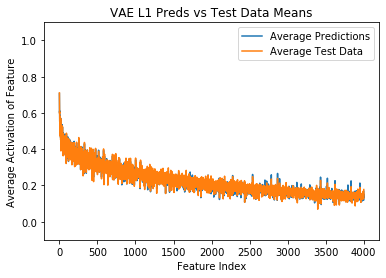

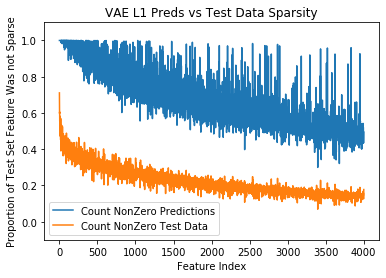

In [23]:
graph_activations(test_data, model_l1_diag, 'VAE L1 Preds vs Test Data Means', 
                  BASE_PATH_DATA + 'vae_l1_activations.png')
graph_sparsity(test_data, model_l1_diag, 'VAE L1 Preds vs Test Data Sparsity', 
                  BASE_PATH_DATA + 'vae_l1_sparsity.png')

del model_l1_diag

In [ ]:
graph_activations(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Means', 
                  BASE_PATH_DATA + 'joint_gumbel_activations.png')
graph_sparsity(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Sparsity', 
                  BASE_PATH_DATA + 'joint_gumbel_sparsity.png')

del joint_vae_gumbel

In [ ]:
graph_activations(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Means', 
                  BASE_PATH_DATA + 'pretrained_gumbel_activations.png')
graph_sparsity(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Sparsity', 
                  BASE_PATH_DATA + 'pretrained_gumbel_sparsity.png')

del vae_gumbel_with_pre

In [ ]:
k_all = [5, 10, 25, 50, 75, 100, 150]#, 250, 500, 1000, 2000, 3000]
n_trials = 10

In [ ]:
losses_pre = []
losses_joint = []

In [ ]:
for k in k_all:
    current_k_pre_losses = []
    current_k_joint_losses = []
    for trial_i in range(n_trials):
        print("RUNNING for K {} Trial {}".format(k, trial_i), flush=True)
        vae_gumbel_with_pre = VAE_Gumbel(input_size, hidden_size, z_size, k = k)
        vae_gumbel_with_pre.to(device)
        vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                        lr=lr, 
                                                        betas = (b1,b2))
    
        joint_vanilla_vae = VAE(input_size, hidden_size, z_size)
        joint_vanilla_vae.to(device)

        joint_vae_gumbel = VAE_Gumbel(input_size, hidden_size, z_size, k = k)
        joint_vae_gumbel.to(device)


        joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + 
                                           list(joint_vae_gumbel.parameters()),
                                                lr=lr, 
                                                betas = (b1,b2))
    
        for epoch in (1, n_epochs + 1):
            train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                              epoch, pretrain_vae, batch_size)
            train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    
        test_loss_pre = 0
        test_loss_joint = 0
        
        inds = np.arange(test_data.shape[0])
        with torch.no_grad():
            for i in range(math.ceil(len(test_data)/batch_size)):
                batch_ind = inds[i * batch_size : (i+1) * batch_size]
                batch_data = test_data[batch_ind, :]
                
                test_pred_pre = vae_gumbel_with_pre(batch_data)[0]
                test_pred_joint = joint_vae_gumbel(batch_data)[0]
                
                test_pred_pre[test_pred_pre < 0.09] = 0
                test_pred_joint[test_pred_joint < 0.09] = 0
                
                test_loss_pre += F.binary_cross_entropy(test_pred_pre, batch_data, reduction='mean')
                test_loss_joint += F.binary_cross_entropy(test_pred_joint, batch_data, reduction='mean')
                
                del batch_data
            
        #test_loss_pre /= len(test_data)
        #test_loss_joint /= len(test_data)
        current_k_pre_losses.append(test_loss_pre.cpu().item())
        current_k_joint_losses.append(test_loss_joint.cpu().item())
        
        # for freeing memory faster
        del vae_gumbel_with_pre
        del vae_gumbel_with_pre_optimizer
        del joint_vanilla_vae
        del joint_vae_gumbel
        del joint_optimizer

        torch.cuda.empty_cache()
        
    
    losses_pre.append(np.mean(current_k_pre_losses))
    losses_joint.append(np.mean(current_k_joint_losses))
    
    
    
fig = plt.figure()
plt.plot(k_all, losses_pre, label = 'Average BCE Losses with Gumbel Matching Pretrained')
plt.plot(k_all, losses_joint, label = 'Average BCE Losses with Gumbel Joint Training')

plt.title("Effect on Sparsity on BCE Loss")
plt.xlabel('Sparsity Level (Number of Non-Zero Features)')
plt.ylabel('Per Neuron Average BCE Loss')
plt.legend()

plt.savefig(BASE_PATH_DATA + 'comparing_across_sparsity.png')